In [1]:
# импортируем необходимые библиотеки numpy и pandas
import numpy as np
import pandas as pd

# настраиваем опции для лучшей отрисовки графиков
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# импортируем класс RandomForestRegressor, который будем использовать 
# в качестве прогнозной модели временного ряда
from sklearn.ensemble import RandomForestRegressor
# импортируем функцию, которая создает необученную модель
# с теми же самыми параметрами, что и у клонированной модели
from sklearn.base import clone

# загружаем данные
from sktime.datasets import load_airline
# импортируем функцию, которая отвечает за разбиение набора на 
# обучающую и тестовую выборки с учетом временной структуры
from sktime.forecasting.model_selection import temporal_train_test_split
# импортируем класс, задающий горизонт прогнозирования
from sktime.forecasting.base import ForecastingHorizon
# импортируем функцию, разбивающую обучающую выборку на серию окон
from sktime.forecasting.compose._reduce import _sliding_window_transform
# импортируем функцию, преобразующую задачу 
# прогнозирования временного ряда в задачу регрессии
from sktime.forecasting.compose import make_reduction
# импортируем функцию для отрисовки графика временного ряда
from sktime.utils.plotting import plot_series
# импортируем функцию, позволяющую вычислить метрику sMAPE/MAPE
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

Задачу прогнозирования временных рядов можно разделить на две категории в зависимости от количества прогнозируемых временных шагов.

  *  Одношаговое прогнозирование - прогнозируется значение только следующего временного шага;
  *  Многошаговое прогнозирование - прогнозируется значение нескольких временных шагов.

Для многошагового прогнозирования предусмотрено 4 типа стратегии:
  
  * **direct** (метод прямого пошагового прогноза) - для каждого временного шага в горизонте прогнозирования обучается отдельная модель.
  
  * **recursive** (метод рекурсивного пошагового прогноза) - включает в себя многократное использование одношаговой модели, в которой прогноз для предыдущего временного шага используется в качестве входных данных для прогнозирования на следующем временном шаге.
  
  * **multioutput** (метод со множеством выходов) - обучается одна модель, которая будет прогнозировать все шаги временного ряда.
  
  * **dirrec** (метод гибридного многошагового прогноза) - комбинация прямой и рекурсивной стратегии, которая позволяет воспользоваться преимуществами обоих методов. Для каждого прогнозируемого временного шага можно построить отдельную модель, но каждая модель может использовать прогнозы, полученные моделями на предыдущих временных шагах, в качестве входных наблюдений.


Разберем более подробно, как это работает

In [2]:
# загрузим первые 50 наблюдений из набора об авиаперевозках
y = load_airline().head(50)
# разбиваем данные на обучающую и тестовую выборки с учетом 
# временной структуры так, чтобы в тестовую выборку попали 
# 12 последних значений временного ряда
y_train, y_test = temporal_train_test_split(y, test_size=12)
# выведем количество наблюдений в обучающей и тестовой выборках
print('TRAIN:', y_train.shape[0], 'TEST:', y_test.shape[0])
# выведем информацию о периодах, охватываемых 
# обучающей и тестовой выборками
print('\nTRAIN:\n', y_train.index[[0, -1]], '\nTEST:\n', y_test.index[[0, -1]])

TRAIN: 38 TEST: 12

TRAIN:
 PeriodIndex(['1949-01', '1952-02'], dtype='period[M]', name='Period') 
TEST:
 PeriodIndex(['1952-03', '1953-02'], dtype='period[M]', name='Period')


In [3]:
# выведем наблюдения обучающего временного ряда
y_train

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
1949-06    135.0
1949-07    148.0
1949-08    148.0
1949-09    136.0
1949-10    119.0
1949-11    104.0
1949-12    118.0
1950-01    115.0
1950-02    126.0
1950-03    141.0
1950-04    135.0
1950-05    125.0
1950-06    149.0
1950-07    170.0
1950-08    170.0
1950-09    158.0
1950-10    133.0
1950-11    114.0
1950-12    140.0
1951-01    145.0
1951-02    150.0
1951-03    178.0
1951-04    163.0
1951-05    172.0
1951-06    178.0
1951-07    199.0
1951-08    199.0
1951-09    184.0
1951-10    162.0
1951-11    146.0
1951-12    166.0
1952-01    171.0
1952-02    180.0
Freq: M, Name: Number of airline passengers, dtype: float64

## Прямой многошаговый прогноз

In [4]:
# задаем относительный горизонт прогнозирования
fh = ForecastingHorizon(np.arange(len(y_test)) + 1)
fh

ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', is_relative=True)

In [5]:
# пишем функцию редукции
def transform(y,
              window_length,
              X=None):    
    """
    Функция превращает временной ряд в таблицу. Она разбивает 
    обучающий временной ряд на окна фиксированной длины 
    (длина определяется параметром window_length).
    Значения, попавшие в окно, будут признаками, а значения, 
    следующие после них, будут значениями зависимой переменной. 
    Мы решаем задачу регреcсии.
    """     
    return _sliding_window_transform(
        y, window_length, fh, X)

In [6]:
# преобразовываем обучающий временной ряд в таблицы,
# получаем сложный массив меток и массив признаков
yt, Xt = transform(y_train,
                   window_length=15)

In [7]:
# взглянем на массив признаков - набор состыкованных окон, видим, что 
# каждый раз окно сдвигается на один шаг вперед
Xt

array([[112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
        118., 115., 126., 141.],
       [118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118.,
        115., 126., 141., 135.],
       [132., 129., 121., 135., 148., 148., 136., 119., 104., 118., 115.,
        126., 141., 135., 125.],
       [129., 121., 135., 148., 148., 136., 119., 104., 118., 115., 126.,
        141., 135., 125., 149.],
       [121., 135., 148., 148., 136., 119., 104., 118., 115., 126., 141.,
        135., 125., 149., 170.],
       [135., 148., 148., 136., 119., 104., 118., 115., 126., 141., 135.,
        125., 149., 170., 170.],
       [148., 148., 136., 119., 104., 118., 115., 126., 141., 135., 125.,
        149., 170., 170., 158.],
       [148., 136., 119., 104., 118., 115., 126., 141., 135., 125., 149.,
        170., 170., 158., 133.],
       [136., 119., 104., 118., 115., 126., 141., 135., 125., 149., 170.,
        170., 158., 133., 114.],
       [119., 104., 118., 115., 126.,

In [8]:
# взглянем на сложный массив меток, видим, что значения, 
# следующие за последним значением каждого окна массива 
# признаков, становится значениями зависимой переменной,
# каждый столбец - зависимая переменная (по сути будет 
# использован как массив меток)
yt

array([[135., 125., 149., 170., 170., 158., 133., 114., 140., 145., 150.,
        178.],
       [125., 149., 170., 170., 158., 133., 114., 140., 145., 150., 178.,
        163.],
       [149., 170., 170., 158., 133., 114., 140., 145., 150., 178., 163.,
        172.],
       [170., 170., 158., 133., 114., 140., 145., 150., 178., 163., 172.,
        178.],
       [170., 158., 133., 114., 140., 145., 150., 178., 163., 172., 178.,
        199.],
       [158., 133., 114., 140., 145., 150., 178., 163., 172., 178., 199.,
        199.],
       [133., 114., 140., 145., 150., 178., 163., 172., 178., 199., 199.,
        184.],
       [114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
        162.],
       [140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
        146.],
       [145., 150., 178., 163., 172., 178., 199., 199., 184., 162., 146.,
        166.],
       [150., 178., 163., 172., 178., 199., 199., 184., 162., 146., 166.,
        171.],
       [178., 163., 1

In [9]:
# создаем экземпляр класса RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)

In [10]:
# для каждого шага в горизонте прогнозирования обучаем отдельную модель

# сюда будем сохранять модели для каждого шага
estimators = []

# для каждого шага в горизонте прогнозирования
for i in range(len(fh)):
    # создаем копию модели
    estimator = clone(regressor)
    # обучаем модель
    estimator.fit(Xt, yt[:, i])
    print('массив меток для {}-й модели: '.format(i), yt[:, i])
    # добавляем обученную модель в общий список моделей
    estimators.append(estimator)

массив меток для 0-й модели:  [135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178.]
массив меток для 1-й модели:  [125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.]
массив меток для 2-й модели:  [149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163. 172.]
массив меток для 3-й модели:  [170. 170. 158. 133. 114. 140. 145. 150. 178. 163. 172. 178.]
массив меток для 4-й модели:  [170. 158. 133. 114. 140. 145. 150. 178. 163. 172. 178. 199.]
массив меток для 5-й модели:  [158. 133. 114. 140. 145. 150. 178. 163. 172. 178. 199. 199.]
массив меток для 6-й модели:  [133. 114. 140. 145. 150. 178. 163. 172. 178. 199. 199. 184.]
массив меток для 7-й модели:  [114. 140. 145. 150. 178. 163. 172. 178. 199. 199. 184. 162.]
массив меток для 8-й модели:  [140. 145. 150. 178. 163. 172. 178. 199. 199. 184. 162. 146.]
массив меток для 9-й модели:  [145. 150. 178. 163. 172. 178. 199. 199. 184. 162. 146. 166.]
массив меток для 10-й модели:  [150. 178. 163. 172. 178. 199. 199. 184. 162. 146

In [11]:
# получим последнее окно (берем последние window_length наблюдений
# обучающего временного ряда)
y_last = y_train.loc['1950-12':'1952-02'].to_numpy()
y_last

array([140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
       146., 166., 171., 180.])

In [12]:
# задаем количество столбцов
n_columns = 1

In [13]:
# зададим длину окна
window_length = 15

In [14]:
# cоздадим массив из нулей
X = np.zeros((1, n_columns, window_length))
X

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [15]:
# запишем в этот массив значения из последнего окна
X[:, 0, :] = y_last
X

array([[[140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180.]]])

In [16]:
# получаем 2-мерный массив - наш новый массив признаков,
# который используем для получения итоговых прогнозов
X = X.reshape(1, -1)
X

array([[140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
        146., 166., 171., 180.]])

In [17]:
# создаем массив из нулей, в который будем записывать прогнозы,
# равный горизонту прогнозирования
y_pred = np.zeros(len(fh))
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
# для каждого шага из горизонта прогнозирования 
# пропускаем новый массив признаков через свою уже обученную модель,
# чтобы получить итоговый прогноз
for i, estimator in enumerate(estimators):
    y_pred[i] = estimator.predict(X)

In [19]:
# напечатаем прогнозы    
print(y_pred)

[162.77 154.84 146.33 151.25 168.78 182.34 179.62 175.34 175.38 183.35
 188.   189.46]


In [20]:
# создаем прогнозную модель, выполнив редукцию
# используем стратегию прямого многошагового прогноза
forecaster = make_reduction(regressor, window_length=15, 
                            strategy='direct')

# обучаем прогнозную модель
forecaster.fit(y_train, fh=fh)

# получаем прогнозы
y_pred_skt = forecaster.predict(fh)

# напечатаем прогнозы    
print(y_pred_skt)

1952-03    162.77
1952-04    154.84
1952-05    146.33
1952-06    151.25
1952-07    168.78
1952-08    182.34
1952-09    179.62
1952-10    175.34
1952-11    175.38
1952-12    183.35
1953-01    188.00
1953-02    189.46
Freq: M, dtype: float64


In [21]:
# cравним прогнозы, вычисленные вручную и автоматически
(y_pred == y_pred_skt.values).all()

True

0.17865107162177962

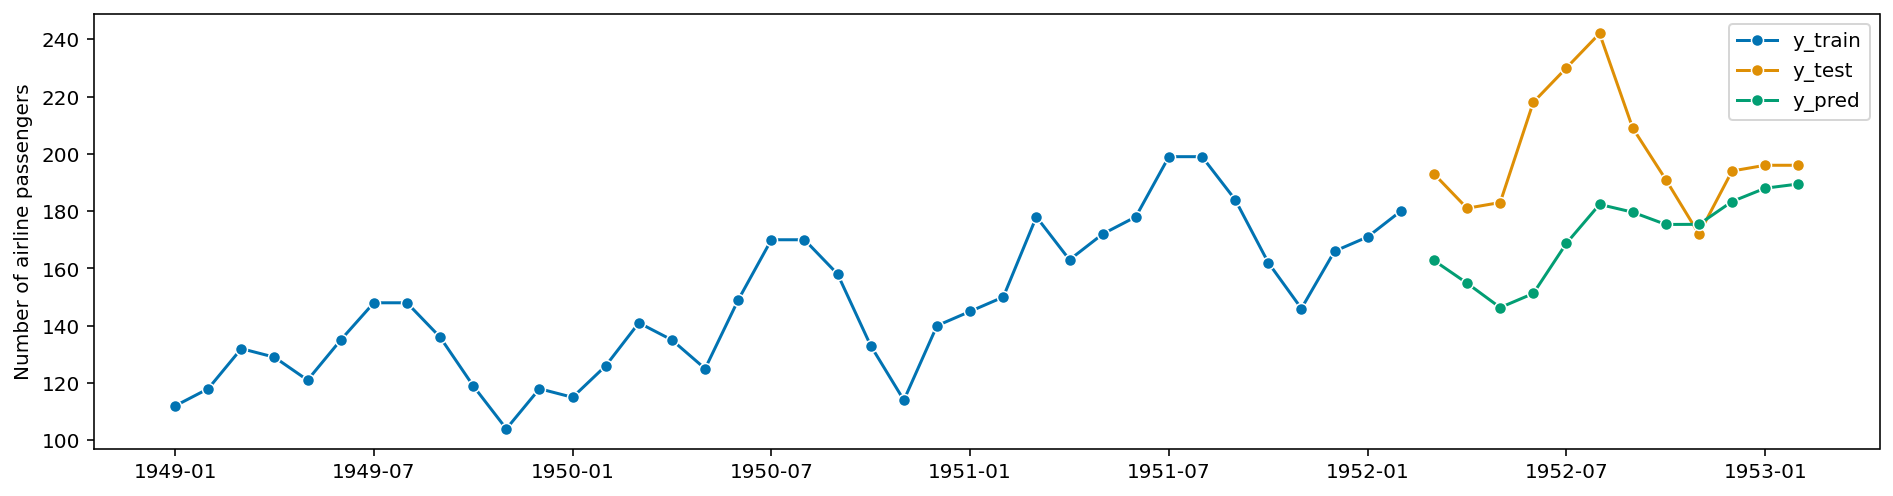

In [22]:
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred_skt, 
            labels=['y_train', 'y_test', 'y_pred'])

# вычисляем sMAPE для тестовой выборки
mean_absolute_percentage_error(y_pred_skt, y_test)

## Рекурсивный многошаговый прогноз

In [23]:
# задаем относительный горизонт прогнозирования
fh = ForecastingHorizon(np.arange(len(y_test)) + 1)
fh

ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', is_relative=True)

In [24]:
# пишем функцию редукции
def transform(y, 
              window_length, 
              X=None):  
    """
    Функция превращает временной ряд в таблицу. Она разбивает 
    обучающий временной ряд на окна фиксированной длины 
    (длина определяется параметром window_length).
    Значения, попавшие в окно, будут признаками, а значения, 
    следующие после них, будут значениями зависимой переменной. 
    Мы решаем задачу регреcсии.
    """
    # для рекурсивной стратегии горизонт прогнозирования 
    # - это просто один шаг вперед, независимо от горизонта 
    # прогнозирования, который мы передаем модели  
    fh = ForecastingHorizon([1]) # всегда прогнозируем на 1 шаг вперед
    
    return _sliding_window_transform(
        y, window_length, fh, X)

In [25]:
# преобразовываем обучающий временной ряд в таблицы,
# получаем массив меток и массив признаков
yt, Xt = transform(y_train,
                   window_length=15)

In [26]:
# взглянем на массив признаков - набор состыкованных окон, 
# видим, что каждый раз окно сдвигается на один шаг вперед
Xt

array([[112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
        118., 115., 126., 141.],
       [118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118.,
        115., 126., 141., 135.],
       [132., 129., 121., 135., 148., 148., 136., 119., 104., 118., 115.,
        126., 141., 135., 125.],
       [129., 121., 135., 148., 148., 136., 119., 104., 118., 115., 126.,
        141., 135., 125., 149.],
       [121., 135., 148., 148., 136., 119., 104., 118., 115., 126., 141.,
        135., 125., 149., 170.],
       [135., 148., 148., 136., 119., 104., 118., 115., 126., 141., 135.,
        125., 149., 170., 170.],
       [148., 148., 136., 119., 104., 118., 115., 126., 141., 135., 125.,
        149., 170., 170., 158.],
       [148., 136., 119., 104., 118., 115., 126., 141., 135., 125., 149.,
        170., 170., 158., 133.],
       [136., 119., 104., 118., 115., 126., 141., 135., 125., 149., 170.,
        170., 158., 133., 114.],
       [119., 104., 118., 115., 126.,

In [27]:
# взглянем на массив меток, видим, что значение, следующее 
# за последним значением каждого окна массива признаков, 
# становится значением зависимой переменной
yt

array([[135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.]])

In [28]:
# сжимаем массив меток до одной оси 
yt = yt.ravel()
yt

array([135., 125., 149., 170., 170., 158., 133., 114., 140., 145., 150.,
       178., 163., 172., 178., 199., 199., 184., 162., 146., 166., 171.,
       180.])

In [29]:
# создаем экземпляр класса RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)
# создаем копию модели
estimator = clone(regressor)
# обучаем модель
estimator.fit(Xt, yt);

In [30]:
# получим последнее окно (берем последние window_length наблюдений
# обучающего временного ряда)
y_last = y_train.loc['1950-12':'1952-02'].to_numpy()
y_last

array([140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
       146., 166., 171., 180.])

In [31]:
# создаем массив из нулей, в который будем записывать прогнозы,
# равный горизонту прогнозирования
y_pred = np.zeros(len(fh))
print('Массив, куда будем сохранять прогнозы:\n\n%s' % y_pred)

Массив, куда будем сохранять прогнозы:

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [32]:
# зададим количество столбцов
n_columns = 1

In [33]:
# зададим длину окна
window_length = 15

In [34]:
# cоздадим массив из нулей, количество элементов определяется
# длиной окна плюс длина горизонта прогнозирования
last = np.zeros((1, n_columns, window_length + len(fh)))
last

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [35]:
# запишем в этот массив значения из последнего окна
last[:, 0, :window_length] = y_last
last

array([[[140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.]]])

In [36]:
# рекурсивно создаем прогнозы для каждого шага горизонта прогнозирования
for i in range(0, len(fh)):
    
    # формируем скользящее окно, в которое отбираем значения, которые будут 
    # использоваться в качестве признаков для i-го наблюдения,
    # каждый раз окно сдвигается на один шаг вперед
    X = last[:, :, i:window_length + i]
    
    # получаем 2-мерный массив признаков
    X = X[0].reshape(1, -1)
    print('Массив признаков для прогнозирования {}-го наблюдения:'.format(i))
    print(X)

    # получаем прогноз для i-го наблюдения
    y_pred[i] = estimator.predict(X)
    print('Прогноз {}-го наблюдения: '.format(i), y_pred[i])

    # добавим i-ый прогноз в массив last
    last[:, 0, window_length + i] = y_pred[i]
    print('----\n')

Массив признаков для прогнозирования 0-го наблюдения:
[[140. 145. 150. 178. 163. 172. 178. 199. 199. 184. 162. 146. 166. 171.
  180.]]
Прогноз 0-го наблюдения:  190.84
----

Массив признаков для прогнозирования 1-го наблюдения:
[[145.   150.   178.   163.   172.   178.   199.   199.   184.   162.
  146.   166.   171.   180.   190.84]]
Прогноз 1-го наблюдения:  186.55
----

Массив признаков для прогнозирования 2-го наблюдения:
[[150.   178.   163.   172.   178.   199.   199.   184.   162.   146.
  166.   171.   180.   190.84 186.55]]
Прогноз 2-го наблюдения:  191.85
----

Массив признаков для прогнозирования 3-го наблюдения:
[[178.   163.   172.   178.   199.   199.   184.   162.   146.   166.
  171.   180.   190.84 186.55 191.85]]
Прогноз 3-го наблюдения:  192.88
----

Массив признаков для прогнозирования 4-го наблюдения:
[[163.   172.   178.   199.   199.   184.   162.   146.   166.   171.
  180.   190.84 186.55 191.85 192.88]]
Прогноз 4-го наблюдения:  192.05
----

Массив признаков д

In [37]:
# напечатаем прогнозы
print(y_pred)

[190.84 186.55 191.85 192.88 192.05 192.05 191.92 185.18 177.67 190.71
 192.01 191.82]


In [38]:
# создаем прогнозную модель, выполнив редукцию
# используем стратегию рекурсивного многошагового прогноза 
forecaster = make_reduction(regressor, window_length=15, 
                            strategy='recursive')

# обучаем прогнозную модель
forecaster.fit(y_train)

# получаем прогнозы
y_pred_skt = forecaster.predict(fh)

# напечатаем прогнозы 
print(y_pred_skt)

1952-03    190.84
1952-04    186.55
1952-05    191.85
1952-06    192.88
1952-07    192.05
1952-08    192.05
1952-09    191.92
1952-10    185.18
1952-11    177.67
1952-12    190.71
1953-01    192.01
1953-02    191.82
Freq: M, dtype: float64


In [39]:
# cравним прогнозы, вычисленные вручную и автоматически
(y_pred == y_pred_skt.values).all()

True

0.07394073164469055

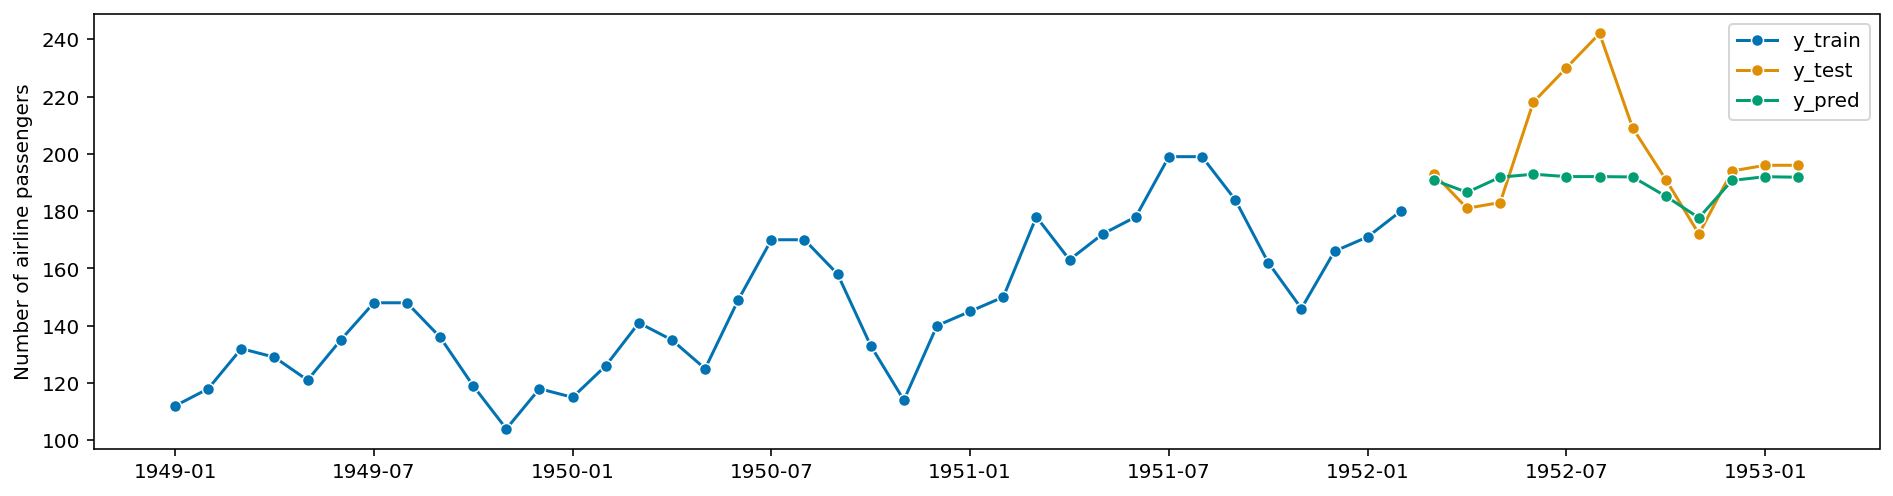

In [40]:
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred_skt, 
            labels=['y_train', 'y_test', 'y_pred'])

# вычисляем sMAPE
mean_absolute_percentage_error(y_pred_skt, y_test)

## Гибридный многошаговый прогноз

In [41]:
# задаем относительный горизонт прогнозирования
fh = ForecastingHorizon(np.arange(len(y_test)) + 1)
fh

ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', is_relative=True)

In [42]:
# пишем функцию редукцию
def transform(y,
              window_length,
              X=None):
    """
    Функция превращает временной ряд в таблицу. Она разбивает 
    обучающий временной ряд на окна фиксированной длины 
    (длина определяется параметром window_length).
    Значения, попавшие в окно, будут признаками, а значения, 
    следующие после них, будут значениями зависимой переменной. 
    Мы решаем задачу регреcсии.
    """       
    return _sliding_window_transform(
        y, window_length, fh, X)

In [43]:
# преобразовываем обучающий временной ряд в таблицы,
# получаем сложный массив меток и массив признаков
yt, Xt = transform(y_train,
                   window_length=15)

In [44]:
# взглянем на массив признаков - набор состыкованных окон, видим, что 
# каждый раз окно сдвигается на один шаг вперед
Xt

array([[112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
        118., 115., 126., 141.],
       [118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118.,
        115., 126., 141., 135.],
       [132., 129., 121., 135., 148., 148., 136., 119., 104., 118., 115.,
        126., 141., 135., 125.],
       [129., 121., 135., 148., 148., 136., 119., 104., 118., 115., 126.,
        141., 135., 125., 149.],
       [121., 135., 148., 148., 136., 119., 104., 118., 115., 126., 141.,
        135., 125., 149., 170.],
       [135., 148., 148., 136., 119., 104., 118., 115., 126., 141., 135.,
        125., 149., 170., 170.],
       [148., 148., 136., 119., 104., 118., 115., 126., 141., 135., 125.,
        149., 170., 170., 158.],
       [148., 136., 119., 104., 118., 115., 126., 141., 135., 125., 149.,
        170., 170., 158., 133.],
       [136., 119., 104., 118., 115., 126., 141., 135., 125., 149., 170.,
        170., 158., 133., 114.],
       [119., 104., 118., 115., 126.,

In [45]:
# взглянем на сложный массив меток, видим, что значения, 
# следующие за последним значением каждого окна массива 
# признаков, становится значениями зависимой переменной
yt

array([[135., 125., 149., 170., 170., 158., 133., 114., 140., 145., 150.,
        178.],
       [125., 149., 170., 170., 158., 133., 114., 140., 145., 150., 178.,
        163.],
       [149., 170., 170., 158., 133., 114., 140., 145., 150., 178., 163.,
        172.],
       [170., 170., 158., 133., 114., 140., 145., 150., 178., 163., 172.,
        178.],
       [170., 158., 133., 114., 140., 145., 150., 178., 163., 172., 178.,
        199.],
       [158., 133., 114., 140., 145., 150., 178., 163., 172., 178., 199.,
        199.],
       [133., 114., 140., 145., 150., 178., 163., 172., 178., 199., 199.,
        184.],
       [114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
        162.],
       [140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
        146.],
       [145., 150., 178., 163., 172., 178., 199., 199., 184., 162., 146.,
        166.],
       [150., 178., 163., 172., 178., 199., 199., 184., 162., 146., 166.,
        171.],
       [178., 163., 1

In [46]:
# преобразовываем 2-мерный массив признаков в 3-мерный
Xt = np.expand_dims(Xt, axis=1)
Xt

array([[[112., 118., 132., 129., 121., 135., 148., 148., 136., 119.,
         104., 118., 115., 126., 141.]],

       [[118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
         118., 115., 126., 141., 135.]],

       [[132., 129., 121., 135., 148., 148., 136., 119., 104., 118.,
         115., 126., 141., 135., 125.]],

       [[129., 121., 135., 148., 148., 136., 119., 104., 118., 115.,
         126., 141., 135., 125., 149.]],

       [[121., 135., 148., 148., 136., 119., 104., 118., 115., 126.,
         141., 135., 125., 149., 170.]],

       [[135., 148., 148., 136., 119., 104., 118., 115., 126., 141.,
         135., 125., 149., 170., 170.]],

       [[148., 148., 136., 119., 104., 118., 115., 126., 141., 135.,
         125., 149., 170., 170., 158.]],

       [[148., 136., 119., 104., 118., 115., 126., 141., 135., 125.,
         149., 170., 170., 158., 133.]],

       [[136., 119., 104., 118., 115., 126., 141., 135., 125., 149.,
         170., 170., 158., 133., 114.]],

 

In [47]:
# конкатенируем 3-мерный массив признаков с 3-мерным массивом меток
X_full = np.concatenate([Xt, np.expand_dims(yt, axis=1)], axis=2)
X_full

array([[[112., 118., 132., 129., 121., 135., 148., 148., 136., 119.,
         104., 118., 115., 126., 141., 135., 125., 149., 170., 170.,
         158., 133., 114., 140., 145., 150., 178.]],

       [[118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
         118., 115., 126., 141., 135., 125., 149., 170., 170., 158.,
         133., 114., 140., 145., 150., 178., 163.]],

       [[132., 129., 121., 135., 148., 148., 136., 119., 104., 118.,
         115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
         114., 140., 145., 150., 178., 163., 172.]],

       [[129., 121., 135., 148., 148., 136., 119., 104., 118., 115.,
         126., 141., 135., 125., 149., 170., 170., 158., 133., 114.,
         140., 145., 150., 178., 163., 172., 178.]],

       [[121., 135., 148., 148., 136., 119., 104., 118., 115., 126.,
         141., 135., 125., 149., 170., 170., 158., 133., 114., 140.,
         145., 150., 178., 163., 172., 178., 199.]],

       [[135., 148., 148., 136., 119., 1

In [48]:
# создаем экземпляр класса RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)

In [49]:
# задаем пустой список, в котором будем сохранять модели 
# для каждого шага в горизонте прогнозирования
estimators = []

In [50]:
# задаем количество временных точек
# (определяется длиной окон в массиве признаков)
n_timepoints = Xt.shape[2]
n_timepoints

15

In [51]:
# для каждого шага в горизонте прогнозирования
for i in range(len(fh)):
    
    # создаем копию модели
    estimator = clone(regressor)

    # создаем массив признаков, используя расширяющееся окно
    X_fit = X_full[:, :, : n_timepoints + i]

    # преобразовываем массив признаков в 2-мерный массив
    X_fit = X_fit.reshape(X_fit.shape[0], -1)
    
    # обучаем модель, используя массив признаков
    estimator.fit(X_fit, yt[:, i])
    print('массив признаков на {}-й итерации:'.format(i))
    print(X_fit)
    print('массив меток на {}-й итерации:'.format(i))
    print(yt[:, i])
    print('')
    
    # добавляем обученную модель в общий список моделей
    estimators.append(estimator)

массив признаков на 0-й итерации:
[[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
  141.]
 [118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126. 141.
  135.]
 [132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126. 141. 135.
  125.]
 [129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126. 141. 135. 125.
  149.]
 [121. 135. 148. 148. 136. 119. 104. 118. 115. 126. 141. 135. 125. 149.
  170.]
 [135. 148. 148. 136. 119. 104. 118. 115. 126. 141. 135. 125. 149. 170.
  170.]
 [148. 148. 136. 119. 104. 118. 115. 126. 141. 135. 125. 149. 170. 170.
  158.]
 [148. 136. 119. 104. 118. 115. 126. 141. 135. 125. 149. 170. 170. 158.
  133.]
 [136. 119. 104. 118. 115. 126. 141. 135. 125. 149. 170. 170. 158. 133.
  114.]
 [119. 104. 118. 115. 126. 141. 135. 125. 149. 170. 170. 158. 133. 114.
  140.]
 [104. 118. 115. 126. 141. 135. 125. 149. 170. 170. 158. 133. 114. 140.
  145.]
 [118. 115. 126. 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145.
  150.]]
масси

In [52]:
# получим последнее окно (берем последние window_length 
# наблюдений обучающего временного ряда)
y_last = y_train.loc['1950-12':'1952-02'].to_numpy()
y_last

array([140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
       146., 166., 171., 180.])

In [53]:
# задаем количество столбцов
n_columns = 1

In [54]:
# задаем длину окна
window_length = 15

In [55]:
# cоздадим массив из нулей
X_full = np.zeros((1, n_columns, window_length + len(fh)))
X_full

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [56]:
# запишем в этот массив значения из последнего окна
X_full[:, 0, :window_length] = y_last
X_full

array([[[140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.]]])

In [57]:
# создаем массив из нулей, в который будем записывать прогнозы,
# равный горизонту прогнозирования
y_pred = np.zeros(len(fh))
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [58]:
# для каждого i-го шага из горизонта прогнозирования
for i in range(len(fh)):
    # на основе X_full создаем массив признаков, 
    # используя расширяющееся окно
    X = X_full[:, :, : window_length + i]
    
    # преобразовываем в 2-мерный массив
    X = X.reshape(1, -1)
    print('Данные для прогнозирования {}-го наблюдения : '.format(i))
    print(X)
    
    # создаем прогноз для i-го наблюдения 
    # с помощью ранее обученной i-й модели
    y_pred[i] = estimators[i].predict(X)
    print('прогноз:', y_pred[i])
    
    # добавляем i-й прогноз в X_full
    X_full[:, :, window_length + i] = y_pred[i]

Данные для прогнозирования 0-го наблюдения : 
[[140. 145. 150. 178. 163. 172. 178. 199. 199. 184. 162. 146. 166. 171.
  180.]]
прогноз: 162.77
Данные для прогнозирования 1-го наблюдения : 
[[140.   145.   150.   178.   163.   172.   178.   199.   199.   184.
  162.   146.   166.   171.   180.   162.77]]
прогноз: 156.19
Данные для прогнозирования 2-го наблюдения : 
[[140.   145.   150.   178.   163.   172.   178.   199.   199.   184.
  162.   146.   166.   171.   180.   162.77 156.19]]
прогноз: 148.16
Данные для прогнозирования 3-го наблюдения : 
[[140.   145.   150.   178.   163.   172.   178.   199.   199.   184.
  162.   146.   166.   171.   180.   162.77 156.19 148.16]]
прогноз: 153.61
Данные для прогнозирования 4-го наблюдения : 
[[140.   145.   150.   178.   163.   172.   178.   199.   199.   184.
  162.   146.   166.   171.   180.   162.77 156.19 148.16 153.61]]
прогноз: 166.87
Данные для прогнозирования 5-го наблюдения : 
[[140.   145.   150.   178.   163.   172.   178.   199.  

In [59]:
# печатаем прогнозы
print(y_pred)

[162.77 156.19 148.16 153.61 166.87 183.04 183.89 179.03 172.81 182.09
 182.18 186.14]


In [60]:
# создаем прогнозную модель, выполнив редукцию
# используем стратегию гибридного многошагового прогноза
forecaster = make_reduction(regressor, window_length=15, 
                            strategy='dirrec')

# обучаем прогнозную модель
forecaster.fit(y_train, fh=fh)

# получаем прогнозы
y_pred_skt = forecaster.predict(fh)

# напечатаем прогнозы 
print(y_pred_skt)

1952-03    162.77
1952-04    156.19
1952-05    148.16
1952-06    153.61
1952-07    166.87
1952-08    183.04
1952-09    183.89
1952-10    179.03
1952-11    172.81
1952-12    182.09
1953-01    182.18
1953-02    186.14
Freq: M, dtype: float64


In [61]:
# cравним прогнозы 
(y_pred == y_pred_skt.values).all()

True

0.1751386948572005

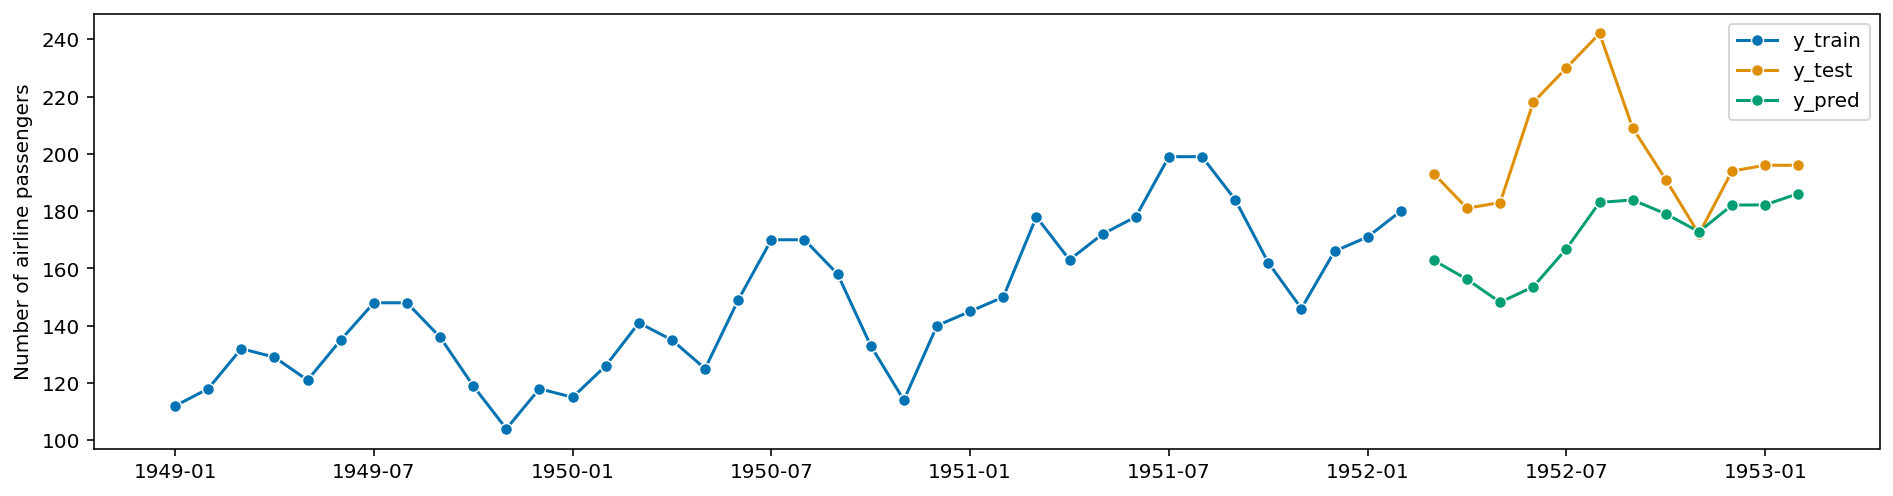

In [62]:
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred_skt, 
            labels=['y_train', 'y_test', 'y_pred'])

# вычисляем sMAPE
mean_absolute_percentage_error(y_pred_skt, y_test)

## Метод прогноза со множеством выходов

In [63]:
# задаем относительный горизонт прогнозирования
fh = ForecastingHorizon(np.arange(len(y_test)) + 1)
fh

ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', is_relative=True)

In [64]:
# пишем функцию редукции
def transform(y,
              window_length,
              X=None):
    """
    Функция превращает временной ряд в таблицу. Она разбивает 
    обучающий временной ряд на окна фиксированной длины 
    (длина определяется параметром window_length).
    Значения, попавшие в окно, будут признаками, а значения, 
    следующие после них, будут значениями зависимой переменной. 
    Мы решаем задачу регреcсии.
    """   
    return _sliding_window_transform(
        y, window_length, fh, X)

In [65]:
# преобразовываем обучающий временной ряд в таблицы,
# получаем сложный массив меток и массив признаков
yt, Xt = transform(y_train,
                   window_length=15)

In [66]:
# взглянем на массив признаков - набор состыкованных окон, видим, что 
# каждый раз окно сдвигается на один шаг вперед
Xt

array([[112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
        118., 115., 126., 141.],
       [118., 132., 129., 121., 135., 148., 148., 136., 119., 104., 118.,
        115., 126., 141., 135.],
       [132., 129., 121., 135., 148., 148., 136., 119., 104., 118., 115.,
        126., 141., 135., 125.],
       [129., 121., 135., 148., 148., 136., 119., 104., 118., 115., 126.,
        141., 135., 125., 149.],
       [121., 135., 148., 148., 136., 119., 104., 118., 115., 126., 141.,
        135., 125., 149., 170.],
       [135., 148., 148., 136., 119., 104., 118., 115., 126., 141., 135.,
        125., 149., 170., 170.],
       [148., 148., 136., 119., 104., 118., 115., 126., 141., 135., 125.,
        149., 170., 170., 158.],
       [148., 136., 119., 104., 118., 115., 126., 141., 135., 125., 149.,
        170., 170., 158., 133.],
       [136., 119., 104., 118., 115., 126., 141., 135., 125., 149., 170.,
        170., 158., 133., 114.],
       [119., 104., 118., 115., 126.,

In [67]:
# взглянем на сложный массив меток, видим, что значения, 
# следующие за последним значением каждого окна массива 
# признаков, становится значениями зависимой переменной,
# каждый столбец - зависимая переменная (по сути будет 
# использован как массив меток)
yt

array([[135., 125., 149., 170., 170., 158., 133., 114., 140., 145., 150.,
        178.],
       [125., 149., 170., 170., 158., 133., 114., 140., 145., 150., 178.,
        163.],
       [149., 170., 170., 158., 133., 114., 140., 145., 150., 178., 163.,
        172.],
       [170., 170., 158., 133., 114., 140., 145., 150., 178., 163., 172.,
        178.],
       [170., 158., 133., 114., 140., 145., 150., 178., 163., 172., 178.,
        199.],
       [158., 133., 114., 140., 145., 150., 178., 163., 172., 178., 199.,
        199.],
       [133., 114., 140., 145., 150., 178., 163., 172., 178., 199., 199.,
        184.],
       [114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
        162.],
       [140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
        146.],
       [145., 150., 178., 163., 172., 178., 199., 199., 184., 162., 146.,
        166.],
       [150., 178., 163., 172., 178., 199., 199., 184., 162., 146., 166.,
        171.],
       [178., 163., 1

In [68]:
# создаем экземпляр класса RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)
# создаем копию модели
estimator = clone(regressor)
# обучаем модель
estimator.fit(Xt, yt);

In [69]:
# получим последнее окно (берем последние window_lenghh 
# наблюдений обучающего временного ряда)
y_last = y_train.loc['1950-12':'1952-02'].to_numpy()
y_last

array([140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
       146., 166., 171., 180.])

In [70]:
# задаем количество столбцов
n_columns = 1

In [71]:
# зададим длину окна
window_length = 15

In [72]:
# cоздадим массив из нулей
X = np.zeros((1, n_columns, window_length))
X

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [73]:
# запишем в этот массив значения из последнего окна
X[:, 0, :] = y_last
X

array([[[140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
         162., 146., 166., 171., 180.]]])

In [74]:
# получаем 2-мерный массив - наш новый массив признаков,
# который используем для получения итоговых прогнозов
X = X.reshape(1, -1)
X

array([[140., 145., 150., 178., 163., 172., 178., 199., 199., 184., 162.,
        146., 166., 171., 180.]])

In [75]:
# получаем прогноз для каждого шага в горизонте прогнозирования
y_pred = estimator.predict(X)
y_pred

array([[154.04, 151.99, 155.91, 159.37, 168.93, 175.02, 175.4 , 171.72,
        166.24, 170.4 , 173.67, 177.33]])

In [76]:
# сжимаем до одной оси
y_pred = y_pred.ravel()
# печатаем прогнозы
print(y_pred)

[154.04 151.99 155.91 159.37 168.93 175.02 175.4  171.72 166.24 170.4
 173.67 177.33]


In [77]:
# создаем экземпляр класса RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)

# создаем прогнозную модель, выполнив редукцию
# используем стратегию прогноза с множеством выходов
forecaster = make_reduction(regressor, window_length=15, 
                            strategy='multioutput')

# обучаем прогнозную модель
forecaster.fit(y_train, fh=fh)

# получаем прогнозы
y_pred_skt = forecaster.predict(fh)

# напечатаем прогнозы 
print(y_pred_skt)

1952-03    154.04
1952-04    151.99
1952-05    155.91
1952-06    159.37
1952-07    168.93
1952-08    175.02
1952-09    175.40
1952-10    171.72
1952-11    166.24
1952-12    170.40
1953-01    173.67
1953-02    177.33
Freq: M, dtype: float64


In [78]:
# сравниваем прогнозы  
(y_pred == y_pred_skt.values).all()

True

0.20337370832317514

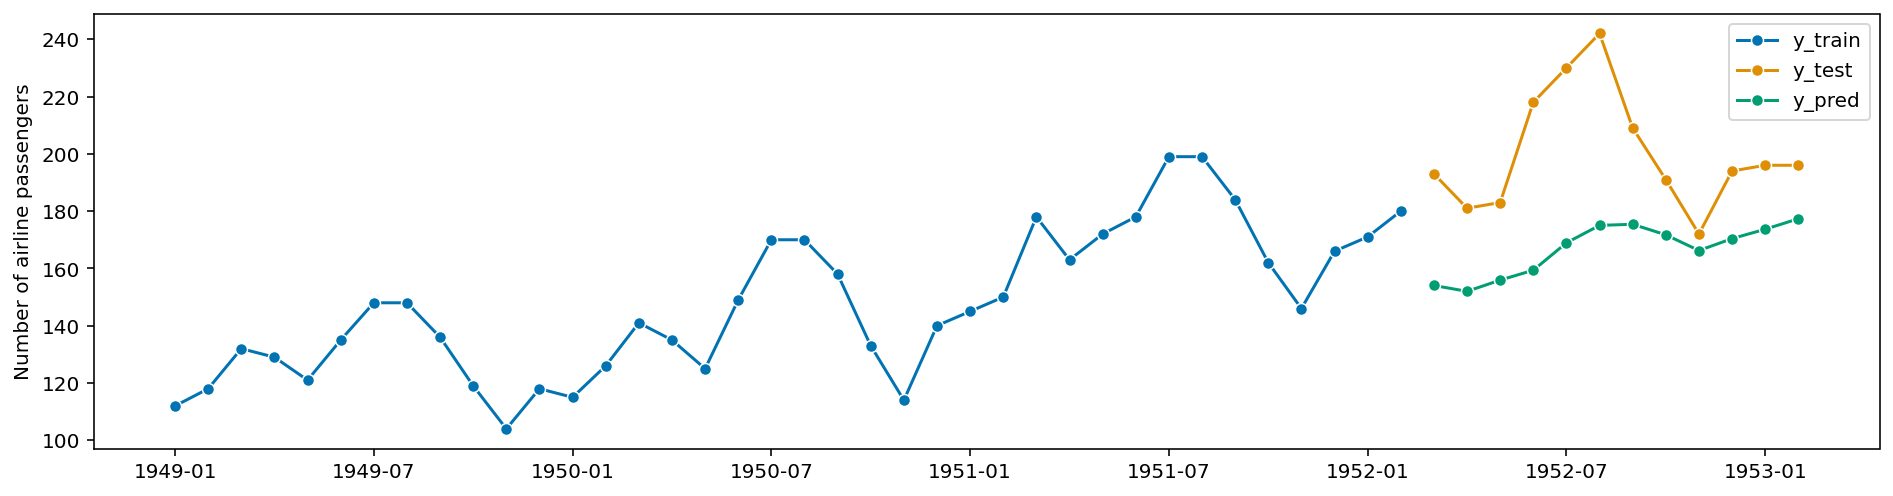

In [79]:
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred_skt, 
            labels=['y_train', 'y_test', 'y_pred'])

# вычисляем sMAPE
mean_absolute_percentage_error(y_pred_skt, y_test)